# Import Libraries

In [1]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
import sqlite3 #for querying data 

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Data Analysis: Statistics and Machine Learning Libraries
from scipy import stats
import scikit_posthocs as sp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Displaying plots in jupter notebook
%matplotlib inline

# Update Jupyter Notebook Display Settings

In [2]:
# Display all columns (pandas will collapse some columns if we don't set this option)
pd.set_option('display.max_columns', None)

# Load Data and Prepare for Analysis

###  Step a: Import data using .read_csv()

In [42]:
# use the .read_csv() method
# We use individual file imports rather than the whole databse because the database is a very large file
# This is a subset
bregman = pd.read_csv('static/documents/bregman')
rendon = pd.read_csv('static/documents/rendon')
soto = pd.read_csv('static/documents/soto')

### Step b: Use .concat() method to combine player dataframes

In [43]:
# Create a list of databases
team = [bregman, rendon, soto]
# Use the .concat() method and pass the list of dataframes
result = pd.concat(team)

### Step c: Replace Batter ID's with Player Last Name

In [44]:
# Option 1:
result['batter'].replace({608324: 'Bregman', 543685: 'Rendon', 665742: 'Soto'}, inplace= True)

### Step d: Delete rows in the 'events' table with missing values
 - we are only interested in batter events and must omit rows that lack this key feature.

In [45]:
# Use the .dropna() method to omit any rows where the column 'events' has a missing value
results = result.dropna(how='any', subset=['events'])

### Step e: Inspect data by using the .pivot_table() method

In [46]:
# Use the .pivot_table() method to display a summary table
# The batter names are used as the index
pivot = results.pivot_table(index="batter", columns='events', aggfunc='size', fill_value=0)
pivot

events,caught_stealing_2b,double,double_play,field_error,field_out,fielders_choice,fielders_choice_out,force_out,grounded_into_double_play,hit_by_pitch,home_run,sac_fly,single,strikeout,strikeout_double_play,triple,walk
batter,,,,,,,,,,,,,,,,,
Bregman,1,40,3,2,309,1,1,18,9,10,45,8,92,95,1,2,128
Rendon,0,51,4,5,288,0,0,7,12,12,37,12,103,96,0,3,81
Soto,1,35,0,5,260,0,0,7,11,4,39,6,92,152,1,5,112


### Plot Entire Season and World Series Home Run Total by player
 - Use individual dataframes
 - Use matplotlib .bar() as a data vis option

In [ ]:
# data to plot
# replace batter id with name
plt.style.use('ggplot')

# Store player names in array 'x'
# Store homerun values in array home_run
x = pivot.home_run.index.values
home_runs = pivot.home_run.values

# Use a list comprehension to create a list of playe positions
x_pos = [i for i, _ in enumerate(x)]

# Create plot and labels
plt.bar(x_pos, home_runs, color='blue', alpha = 0.7)
plt.xlabel("Players")
plt.ylabel("Home Runs")
plt.title("Total Home Runs (Including World Series)")
plt.xticks(x_pos, x)

plt.savefig("static/images/total_home_runs.png", bbox_inches='tight') 
plt.show()


Soto made more Home Runs than Rendon, when counting playoffs and world series.

# Objective 1: Evaluate Player Batting Events

In [ ]:
order = result.events.value_counts().index

sns.set(rc={'figure.figsize':(25,15)})
sns.set(font_scale=1.5)
result_events = sns.countplot(x='events', hue = "batter", data=result, order=order)
result_events.set_xticklabels(result_events.get_xticklabels(), rotation=45)
fig = result_events.get_figure()
fig.savefig("static/images/batter_event_bar_plots.png", bbox_inches='tight') 

In [ ]:
# Determine the number of batted events per player
results.groupby('batter')['events'].agg('count')

In [ ]:
# Home run rate
print(f'Bregman HR rate {45/765 * 100}, Rendon HR Rate {37/711* 100}, Soto HR Rate {39/730* 100}')

# Objective 2: Determine which player had the highest hit distance

## Obj 2 Step 1: Clean Data

In [195]:
# Clearn up data by removing an NaN
# Use the .dropna() method to omit any rows where the column 'events' has a missing value
results_hd = results.dropna(how='any', subset=['hit_distance_sc'])

In [196]:
# Filter by player and only for home run events
bregman_hd = results_hd[(results_hd["batter"] == "Bregman") & (results_hd["events"] == "home_run")]
rendon_hd = results_hd[(results_hd["batter"] == "Rendon") & (results_hd["events"] == "home_run")]
soto_hd = results_hd[(results_hd["batter"] == "Soto") & (results_hd["events"] == "home_run")]

In [197]:
# Combine filtered data
frames = [bregman_hd, rendon_hd, soto_hd]
filterd_hd = pd.concat(frames)

## Obj 2 Step 2: Aggregate Descriptive Statistics

In [ ]:
bregman_hd_metrics = bregman_hd[["hit_distance_sc"]].describe()
bregman_hd_metrics = bregman_hd_metrics.rename(columns={"hit_distance_sc" : "Bregman Hit Distance"})
rendon_hd_metrics = rendon_hd[["hit_distance_sc"]].describe()
rendon_hd_metrics = rendon_hd_metrics.rename(columns={"hit_distance_sc" : "Rendon Hit Distance"})
soto_hd_metrics = soto_hd[["hit_distance_sc"]].describe()
soto_hd_metrics = soto_hd_metrics.rename(columns={"hit_distance_sc" : "Soto Hit Distance"})
frames = [bregman_hd_metrics,rendon_hd_metrics,soto_hd_metrics]
hd_stats = pd.concat(frames, axis = 1)
hd_stats

## Obj 2 Step 3: Visualize Hit Distance 

In [ ]:
sns.set(font_scale=2)
ax = sns.boxplot(x="batter", y="hit_distance_sc", data=filterd_hd)
ax.set(xlabel='Player', ylabel='Hit Distance (ft)')
plt.savefig("static/images/hit_distance_boxplot.png", bbox_inches='tight')
plt.show()

 Soto seems to have the longest hit distances, but need to confirm if this is statistically significant

## Obj 2 Step 4: Determine if there is a statistical difference in the hit distance between players

### Obj2 Step 4a: Determine if the data is normally distrbuted using graphical approaches

In [ ]:
fig1, axs1 = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 10))
sns.distplot(bregman_hd["hit_distance_sc"], color='tab:blue', ax=axs1[0]).set_title('Alex Bregman \n Hit Distance, 2019')
sns.distplot(rendon_hd["hit_distance_sc"], color='tab:blue', ax=axs1[1]).set_title('Anthony Rendon \n Hit Distance, 2019')
sns.distplot(soto_hd["hit_distance_sc"], color='tab:blue', ax=axs1[2]).set_title('Juan Soto \n Hit Distance, 2019')
fig1.savefig("static/images/hit_distance_distplot.png", bbox_inches='tight')

The curves appear normally distributed, but need to follow up with a shapiro-wilk test.

### Obj2 Step 4b:  Determine if the data is normally distrbuted using Shapiro-Wilk Test

In [ ]:
# Use the scipy.stats.shapiro test for normality
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# Bregman
breg_sw_test = [stats.shapiro(bregman_hd["hit_distance_sc"])[0], stats.shapiro(bregman_hd["hit_distance_sc"])[1]]
rendon_sw_test = [stats.shapiro(rendon_hd["hit_distance_sc"])[0], stats.shapiro(rendon_hd["hit_distance_sc"])[1]]
soto_sw_test = [stats.shapiro(soto_hd["hit_distance_sc"])[0], stats.shapiro(soto_hd["hit_distance_sc"])[1]]
Shapiro_Wilk_df = pd.DataFrame({"bregman": breg_sw_test, "rendon": rendon_sw_test, "soto": soto_sw_test}, index = ["W", "p-value"])

In [ ]:
# The p-value for the test does not reject the Ho. Data is normally distributed
Shapiro_Wilk_df

The p-values for all the players Shapiro-Wilk test are above 0.05, which suggest that we cannot reject the null hypothesis that the samples came from a normal distribution.

### Obj2 Step 4c: Test for equal variance  using the Barlette's test

In [ ]:
# Test for equal variance
# scipy.stats.bartlett because I know the samples are normally distributed
barlette_result = stats.bartlett(bregman_hd["hit_distance_sc"], rendon_hd["hit_distance_sc"], soto_hd["hit_distance_sc"])
if barlette_result[1] >= 0.05:
    print("Do not reject the null hypothesis, the all input samples are from populations with equal variances.")
else:
    print("Reject the null hypothesis, the samples do not have equal variance")

The home run distance data is parametric and we can use an ANOVA to determine if there is a difference in the hit distance between players.

### Obj2 Step 4d: Conduct an ANOVA Test for Variance

In [ ]:
# The conditions to test an ANOVA have been met
anova_hd = stats.f_oneway(bregman_hd["hit_distance_sc"], rendon_hd["hit_distance_sc"], soto_hd["hit_distance_sc"])
if anova_hd[1] >= 0.05:
    print(f"The p-value is: {anova_hd[1]}. Do not reject the null hypothesis, no difference in hit distance amongst batters.")
else:
    print(f"The p-value is: {anova_hd[1]}. Reject the null hypothesis, there is a difference in the hit distance amongs batters.")

### Obj2 Step 4e: Conduct a Post hoc test using Tukey's to determine which variables differ significantly

In [ ]:
import scikit_posthocs as sp
sp.posthoc_tukey(filterd_hd, val_col='hit_distance_sc', group_col='batter')

There is a difference in the hit distance between 
 - Bregman and Rendon
 - Bregman and Soto
 - Rendon and Bregman
 - Soto and Bregman<br>
This suggets that Both Rendon and Soto have a higher hit distance than Bregman, but no difference between Soto and Rendon.

# Objective 3: Determine the impact of launch speed and launch angle on Home Runs

## Obj 3 Step 1: Use Support Vector Machines to predict home runs using launch speed and launch angles

### Obj 3 Step 1a: Prepare MLB 2019 Season Data for Analysis

In [3]:
# Connect to the database using the .connect() method
# This will only connect to the website data, once you save the data as either a csv or db, 
# you will need to reconnect with the correct filepath
conn = sqlite3.connect('/Users/trinitycisneros/Documents/Coding/bitterscientist.com/statcast.db')
season2019_df = pd.read_sql_query("SELECT events, launch_angle, launch_speed FROM statcast;", conn)
season2019_df.to_csv('/Users/trinitycisneros/Documents/Coding/bitterscientist.com/season2019_logreg')
conn.close() 

#### Clean data (remove nan, and change datatypes)

In [4]:
# Drop any rows that have missing values, as we can't use this data in the analysis
season2019_df = season2019_df.dropna(how='any')

In [5]:
# Will change datatypes columns
float_cols = ['launch_angle','launch_speed']
cat_col = ['events']

In [6]:
# Converts columns into floats
for col in float_cols:
    season2019_df[col] = season2019_df[col].astype('float')

In [7]:
# Convert events column into category
for col in cat_col:
    season2019_df[col] = season2019_df[col].astype('category')

In [8]:
# Prepare data for analysis, use .get_dummies() to get binary array for each event
dummy_df = pd.get_dummies(season2019_df)

In [9]:
# Create new dataframe 
dummy_df = dummy_df[['launch_angle', 'launch_speed', 'events_home_run']].copy()

### Obj 3 Step 1b: Plot all events and examine which ones are home runs

In [ ]:
# Plot all events
ax = sns.scatterplot(x="launch_speed", y="launch_angle", hue="events_home_run", data=dummy_df)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.90), ncol=1)
plt.savefig("static/images/events_home_run.png", bbox_inches='tight')

### Obj 3 Step 1c: Prepare Variables for Analysis

In [52]:
# Assign predictor variables to X and target variable to y
X = dummy_df[['launch_angle', 'launch_speed']]
y = dummy_df['events_home_run']

In [74]:
# X_train, X_test, y_train, y_test = train_test_split(
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [153]:
svc = svm.SVC(kernel='rbf', gamma=1).fit(X_train, y_train)

In [154]:
print("Accuracy on trainig set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on trainig set: 0.97
Accuracy on test set: 0.97


In [155]:
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
import itertools

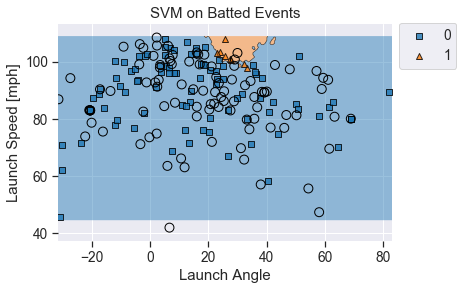

In [156]:
# Plotting decision regions
plot_decision_regions(X[:100], y.values[:100], clf=svc, legend=2, X_highlight=X_test.values[:100])

# Adding axes annotations
plt.xlabel('Launch Angle')
plt.ylabel('Launch Speed [mph]')
plt.title('SVM on Batted Events')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.90), ncol=1)
plt.savefig("static/images/svg_batted_events.png", bbox_inches='tight')
plt.show()

### Obj 3 Step 1d: Evaluate the Performance of the Model

In [157]:
# Obtain the predictation value for the testing data set
y_pred = svc.predict(X_test)

In [158]:
# Prepare a confusion matrix (tn, fp, fn, tp)
cm = confusion_matrix(y_test, y_pred)

In [165]:
# In the binary case, we can extract true positives, etc as follows:
cm_unravel = cm.ravel()
tn, fp, fn, tp = cm_unravel
print(tn, fp, fn, tp)

35970 427 658 1403


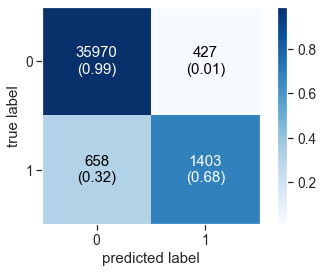

In [162]:
from mlxtend.plotting import plot_confusion_matrix


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.savefig("static/images/svg_confusion_matrix.png", bbox_inches='tight')
plt.show()

In [163]:
# Prepare a classification report
report = classification_report(y_test, y_pred, output_dict=True)

cr_df = pd.DataFrame(report).transpose()

In [164]:
cr_df

,precision,recall,f1-score,support
0,0.982036,0.988268,0.985142,36397.000000
1,0.766667,0.680738,0.721151,2061.000000
accuracy,0.971787,0.971787,0.971787,0.971787
macro avg,0.874351,0.834503,0.853147,38458.000000
weighted avg,0.970494,0.971787,0.970995,38458.000000


## Obj 3 Step 2: Assess the Launch Speed and Launch Angle for each player
 - These two variables have been reported to play an important role in home run events
 - This data uses the results dataframe that combines all players and drops any missing event

### Alex Bregman batted events by launch speed and launch angle

In [ ]:
# Alex Bregman
fig1, axs1 = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(10, 10))
sns.set(font_scale=1.25)
sns.scatterplot(x="launch_speed", y="launch_angle", hue="events", data= results[results["batter"] == "Bregman"]).set_title('Alex Bregman\nBatter Events, 2019')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), ncol=1)
fig1.savefig("static/images/bregman_events_angle_speed.png", bbox_inches='tight')
plt.show()

The home runs appear clustered between 20-40 angles and above 90 mph 

### Athony Rendon batted events by launch speed and launch angle

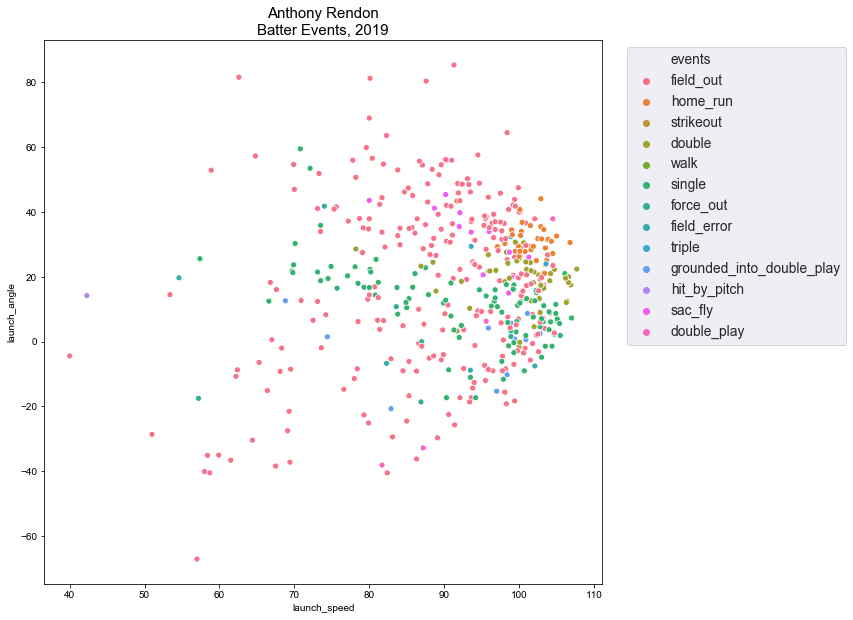

In [105]:
# Anthony Rendon
fig1, axs1 = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(10, 10))
sns.set(font_scale=1.25)
sns.scatterplot(x="launch_speed", y="launch_angle", hue="events", data= results[results["batter"] == "Rendon"]).set_title('Anthony Rendon\nBatter Events, 2019')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), ncol=1)
fig1.savefig("static/images/rendon_events_angle_speed.png", bbox_inches='tight')
plt.show()

The home runs appear clustered between 20-40 angles and above 95 mph 

### Juan Soto batted events by launch speed and launch angle

In [ ]:
# Juan Soto
fig1, axs1 = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(10, 10))
sns.set(font_scale=1.25)
sns.scatterplot(x="launch_speed", y="launch_angle", hue="events", data= results[results["batter"] == "Soto"]).set_title('Juan Soto\nBatter Events, 2019')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), ncol=1)
fig1.savefig("static/images/soto_events_angle_speed.png", bbox_inches='tight')
plt.show()

The home runs appear clustered between 20-40 angles and above 100 mph 

## Obj 3 Step 3: Evaluate Home Run Data
 - To focus on the launch angle and speed in home run activity
 - Data used here is the original dataframe that was imported from CSV
 - this data does not have any event filtered, but thats because a home run is an event

### Obj 3 Step 3a: Filter data by player and by home runs
 - use this method because we don't have to go through a series of filters using the combined results dataframe

In [ ]:
# Filter to include home runs only
bregman_hr = bregman[bregman["events"] == "home_run"]
rendon_hr = rendon[rendon["events"] == "home_run"]
soto_hr = soto[soto["events"] == "home_run"]

### Obj 3 Step 3b: Compare the descriptive statistics for speed and launch angle
 -  Combine descriptive statistics by player into a single dataframe

In [ ]:
bregman_hr_metrics = bregman_hr[["launch_speed", "launch_angle"]].describe()
bregman_hr_metrics = bregman_hr_metrics.rename(columns={"launch_speed" : "Bregman Speed", "launch_angle": "Bregman Angle"})
rendon_hr_metrics = rendon_hr[["launch_speed", "launch_angle"]].describe()
rendon_hr_metrics = rendon_hr_metrics.rename(columns={"launch_speed" : "Rendon Speed", "launch_angle": "Rendon Angle"})
soto_hr_metrics = soto_hr[["launch_speed", "launch_angle"]].describe()
soto_hr_metrics = soto_hr_metrics.rename(columns={"launch_speed" : "Soto Speed", "launch_angle": "Soto Angle"})
frames = [bregman_hr_metrics,rendon_hr_metrics,soto_hr_metrics]
hr_stats = pd.concat(frames, axis = 1)
hr_stats

### Obj 3 Step 3c:  Visualize the launch angle and launch speed for home runs by player

In [ ]:
# Create a figure with three scatter plots of launch speed vs. launch angle, one for each player's home runs
fig1, axs1 = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10, 5))
sns.set(font_scale=1)
sns.regplot(x=bregman_hr["launch_speed"], y=bregman_hr["launch_angle"], fit_reg=False, color='tab:blue', data=bregman_hr, ax=axs1[0]).set_title('Alex Bregman\nHome Runs, 2019')
sns.regplot(x=rendon_hr["launch_speed"], y=rendon_hr["launch_angle"], fit_reg=False, color='tab:blue', data=rendon_hr, ax=axs1[1]).set_title('Anthony Rendon\nHome Runs, 2019')
sns.regplot(x=soto_hr["launch_speed"], y=soto_hr["launch_angle"], fit_reg=False, color='tab:blue', data=soto_hr, ax=axs1[2]).set_title('Juan Soto\nHome Runs, 2019')
fig1.savefig("static/images/angle_speed.png", bbox_inches='tight')

## Obj 3 Step 4: Conduct statistical analysis to determine if launch speed differs among players
 - does speed explain the difference in the difference in home runs?

### Obj 3 Step 4a: test for normality using Shapiro-Wilk Test

In [ ]:
# Use the scipy.stats.shapiro test for normality
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# Bregman
breg_sw_speed_test = [stats.shapiro(bregman_hd["launch_speed"])[0], stats.shapiro(bregman_hd["launch_speed"])[1]]
rendon_sw_speed_test = [stats.shapiro(rendon_hd["launch_speed"])[0], stats.shapiro(rendon_hd["launch_speed"])[1]]
soto_sw_speed_test = [stats.shapiro(soto_hd["launch_speed"])[0], stats.shapiro(soto_hd["launch_speed"])[1]]
Shapiro_Wilk_speed_df = pd.DataFrame({"bregman": breg_sw_speed_test, "rendon": rendon_sw_speed_test, "soto": soto_sw_speed_test}, index = ["W", "p-value"])

The launch speed for Anthony Rendon does not seem to follow a normal distribution, as the p-value < 0.05

### Obj 3 Step 4b: test the launch angle for normality using Shapiro-Wilk Test

In [ ]:
# Use the scipy.stats.shapiro test for normality
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# Bregman
breg_sw_angle_test = [stats.shapiro(bregman_hd["launch_angle"])[0], stats.shapiro(bregman_hd["launch_angle"])[1]]
rendon_sw_angle_test = [stats.shapiro(rendon_hd["launch_angle"])[0], stats.shapiro(rendon_hd["launch_angle"])[1]]
soto_sw_angle_test = [stats.shapiro(soto_hd["launch_angle"])[0], stats.shapiro(soto_hd["launch_angle"])[1]]
Shapiro_Wilk_angle_df = pd.DataFrame({"bregman": breg_sw_angle_test, "rendon": rendon_sw_angle_test, "soto": soto_sw_angle_test}, index = ["W", "p-value"])

In [ ]:
Shapiro_Wilk_angle_df

The Shapiro-Wilk test confirms that the launch angle is normally distributed

### Obj 3 Step 4c: determine if samples have equal variance using Barlette's test

In [ ]:
# Test for equal variance
# scipy.stats.bartlett because I know the samples are normally distributed
barlette_angle = stats.bartlett(bregman_hd["launch_angle"], rendon_hd["launch_angle"], soto_hd["launch_angle"])
if barlette_angle[1] >= 0.05:
    print("Do not reject the null hypothesis, all the input samples are from a populations with equal variances.")
else:
    print("Reject the null hypothesis, the samples do not have equal variance")

### Obj 3 Step 4d: Conduct an ANOVA to determine if there is a significant differnece in the angles between players

In [ ]:
# The conditions to test an ANOVA have been met
anova_angle = stats.f_oneway(bregman_hd["launch_angle"], rendon_hd["launch_angle"], soto_hd["launch_angle"])
if anova_angle[1] >= 0.05:
    print(f"The p-value is: {anova_angle[1]}. Do not reject the null hypothesis, no difference in launch angle amongst batters.")
else:
    print(f"The p-value is: {anova_angle[1]}. Reject the null hypothesis, there is a difference in the launch angle amongs batters.")

### Obj 3 Step 4e: Calculate the Pearson Correlation for those conditions that are normally distributed

In [ ]:
# Calculate pearson coefficient and p-value Bregman
bregman_pearson = stats.pearsonr(bregman_hr["launch_speed"], bregman_hr["launch_angle"])
bregman_pearson

In [ ]:
# Calculate pearson coefficient and p-value Soto
soto_pearson = stats.pearsonr(soto_hr["launch_speed"], soto_hr["launch_angle"])
soto_pearson

### Obj 3 Step 4f: Calculate the Spearman R for those conditions that are not normally distributed

In [ ]:
bregman_spearmanr = stats.spearmanr(bregman_hr["launch_speed"], bregman_hr["launch_angle"])
rendon_spearmanr = stats.spearmanr(rendon_hr["launch_speed"], rendon_hr["launch_angle"])
soto_spearmanr = stats.spearmanr(soto_hr["launch_speed"], soto_hr["launch_angle"])
player_spearmanr = pd.DataFrame({"bregman": bregman_spearmanr, "rendon": rendon_spearmanr, "soto": soto_spearmanr}, index = ["rho", "p-value"])

In [ ]:
player_spearmanr

The p value for breman suggest that it is statistically significant

## Obj 3 Step 5: Visualize Launch Speed vs Launch Angle in Home Run Events

### Obj 3 Step 5a: Alex Bregman plot

In [ ]:
# Bregman
sns.jointplot(x='launch_speed',y='launch_angle',data=bregman_hr, kind='reg')
plt.savefig("static/images/bregman_join_plot_angle_speed.png", bbox_inches='tight')
plt.show()

### Obj 3 Step 5a: Anthony Rendon plot

In [ ]:
# Rendon
sns.jointplot(x='launch_speed',y='launch_angle',data=rendon_hr, kind='reg')
plt.savefig("static/images/rendon_join_plot_angle_speed.png", bbox_inches='tight')
plt.show()

### Obj 3 Step 5a: Juan Soto plot

In [ ]:
# Soto
sns.jointplot(x='launch_speed',y='launch_angle',data=soto_hr, kind='reg')
plt.savefig("static/images/soto_join_plot_angle_speed.png", bbox_inches='tight')
plt.show()

## Obj3 Step 6: Compute the Kruskal-Wallis H-test for independent samples

In [ ]:
kruskal_wallis_h = stats.kruskal(bregman_hd["launch_speed"], rendon_hd["launch_speed"], soto_hd["launch_speed"])

In [ ]:
if kruskal_wallis_h[1] >= 0.05:
    print(f"The p value is : {kruskal_wallis_h}. Do not reject the null hypothesis, no difference in the launch speed amongst batters.")
else:
    print(f"The p value is : {kruskal_wallis_h} Reject the null hypothesis, there is a difference in the launch speed amongs batters.")

## Obj3 Step 7 Post hoc test using scikit-posthocs 0.6.1

In [ ]:
dunn = sp.posthoc_dunn(filterd_hd, val_col="launch_speed", group_col='batter', p_adjust = 'holm')
dunn

There is no difference in the launch angle between players<br>
The launch speed between 
 - Soto and Bregman is significantlly different
 - Rendon and Soto is significantly different<br>
<br>

# Objective 4: Determine the impact of pitch velocity on Home Runs

### Obj 4 Step 4a: Summary Statistics for the pitch velocity "release_speed" for each event that results in a home run

In [169]:
# Connect to the database using the .connect() method
# This will only connect to the website data, once you save the data as either a csv or db, 
# you will need to reconnect with the correct filepath
conn = sqlite3.connect('/Users/trinitycisneros/Documents/Coding/bitterscientist.com/statcast.db')
season2019_rs_df = pd.read_sql_query("SELECT release_speed, events FROM statcast;", conn)
conn.close() 

In [174]:
# Pitch speeds for all events
season2019_rs_df = season2019_rs_df.dropna(how='any').copy()

In [175]:
season2019_rs_df['release_speed'].describe()

count    187528.000000
mean         88.793753
std           5.832647
min          51.500000
25%          84.600000
50%          89.800000
75%          93.500000
max         104.300000
Name: release_speed, dtype: float64

In [188]:
mean_rs_pivot = results.groupby(["batter"])["release_speed"].mean()
sd_rs_pivot = results.groupby(["batter"])["release_speed"].std()
frames = [mean_rs_pivot,sd_rs_pivot]
player_rs_stats = pd.concat(frames, axis = 1)
player_rs_stats.columns = ["RS Mean", "RS SD "]
player_rs_stats

,RS Mean,RS SD
batter,,
Bregman,89.310013,5.668896
Rendon,89.854993,5.498450
Soto,88.870274,5.844168


In [199]:
# Using the player_hr dataframe because it has been filtered for home run events

# Bregman
bregman_hr_rs = bregman_hr[["release_speed"]].describe()
bregman_hr_rs = bregman_hr_rs.rename(columns={"release_speed" : "Bregman rs"})

# Rendon
rendon_hr_rs = rendon_hr[["release_speed"]].describe()
rendon_hr_rs = rendon_hr_rs.rename(columns={"release_speed" : "Rendon rs"})

# Soto
soto_hr_rs = soto_hr[["release_speed"]].describe()
soto_hr_rs = soto_hr_rs.rename(columns={"release_speed" : "Soto rs"})

# Combine summary stats into a single table
frames = [bregman_hr_rs,rendon_hr_rs,soto_hr_rs]
rs_stats = pd.concat(frames, axis = 1)
rs_stats

NameError: name 'bregman_hr' is not defined

It appears as if Soto bats against higher pitch velocities.

### Obj 4 Step 4b: Visualize distribution of pitch velocity for each player

NameError: name 'bregman_hr' is not defined

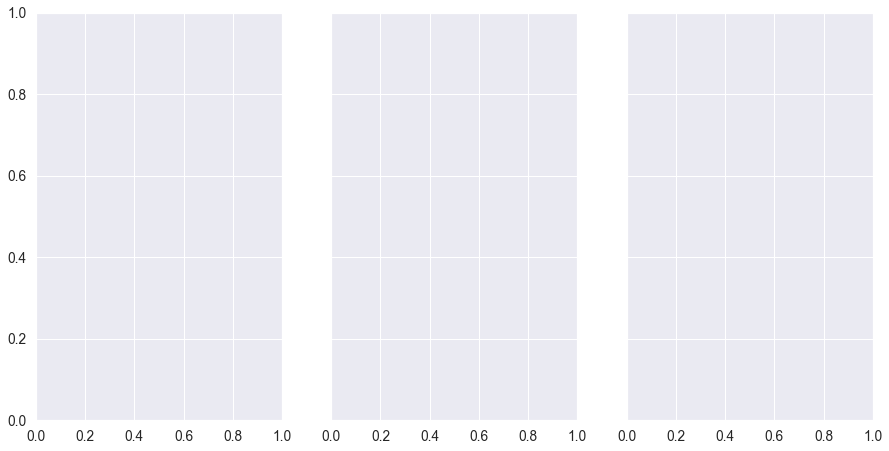

In [198]:
# Create a boxplot that describes the pitch velocity of each player's home runs
fig1, axs1 = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 7.5))
sns.boxplot(bregman_hr["release_speed"], color='tab:blue', ax=axs1[0]).set_title('Alex Bregman \n Home Runs, 2019')
sns.boxplot(rendon_hr["release_speed"], color='tab:blue', ax=axs1[1]).set_title('Anthony Rendon \n Home Runs, 2019')
sns.boxplot(soto_hr["release_speed"], color='tab:blue', ax=axs1[2]).set_title('Juan Soto \n Home Runs, 2019')
fig1.savefig("static/images/release_speed.png", bbox_inches='tight')

### Obj 4 Step 4c: Determine if the release_speed differes for all batted events between players (in other words, did any player have to hit the ball against faster, or slower pitches)

In [189]:
# Used the entire dataset for this one, but dropped any instance that 
# does not have a release_speed associated
results_rs = result.dropna(how='any', subset=['release_speed'])

In [190]:
# Filterd by player
bregman_rs = results_rs[results_rs["batter"] == "Bregman"]["release_speed"]
rendon_rs = results_rs[results_rs["batter"] == "Rendon"]["release_speed"]
soto_rs = results_rs[results_rs["batter"] == "Soto"]["release_speed"]

In [191]:
# Anova
anova_rs = stats.f_oneway(bregman_rs, rendon_rs, soto_rs)

In [200]:
if anova_rs[1] >= 0.05:
    print(f"Do not reject the null hypothesis, the p value is {anova_rs[1]} no difference in the pitch velocity amongst batters.")
else:
    print(f"Reject the null hypothesis, the p value is {anova_rs[1]}, there is a difference in the pitch velocity amongs batters.")

Reject the null hypothesis, the p value is 0.0007012785310057842, there is a difference in the pitch velocity amongs batters.


### Obj 4 Step 4d: Conduct a post hoc test to determine which players here significantly different

In [203]:
results_rs.groupby(["batter"])["release_speed"].mean()

batter
Bregman    88.904872
Rendon     89.216592
Soto       88.637277
Name: release_speed, dtype: float64

In [193]:
# x = [bregman_hd["launch_speed"], rendon_hd["launch_speed"], soto_hd["launch_speed"]]
dunn = sp.posthoc_dunn(results_rs, val_col="release_speed", group_col='batter', p_adjust = 'holm')
dunn

,Bregman,Rendon,Soto
Bregman,-1.000000,0.055849,0.060761
Rendon,0.055849,-1.000000,0.000174
Soto,0.060761,0.000174,-1.000000


There is a difference in the pitch velocity between Soto and Rendon<br>
No difference in the pitch velocity between:
 - Bregman and Rendon
 - Bregman and Soto<br>

# Obj 5: Determine the Player's Pitch Locations

### Obj 5 Step 1: Functions to assign the x and y coordinate for the pitch location

In [ ]:
def assign_x_coord(row):
    """
    Assigns an x-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Left third of strike zone
    if row.zone in [1, 4, 7]:
        return 1
    # Middle third of strike zone
    if row.zone in [2, 5, 8]:
        return 2
    # Right third of strike zone
    if row.zone in [3, 6, 9]:
        return 3

In [ ]:
def assign_y_coord(row):
    """
    Assigns a y-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Upper third of strike zone
    if row.zone in [1, 2, 3]:
        return 3
    # Middle third of strike zone
    if row.zone in [4, 5, 6]:
        return 2
    # Lower third of strike zone
    if row.zone in [7, 8, 9]:
        return 1

### Obj 5 Step 2a:  Alex Bregman's home run zone

In [ ]:
# Zones 11, 12, 13, and 14 are to be ignored for plotting simplicity
bregman_strikes_hr = bregman_hr.copy().loc[bregman_hr.zone <= 9]

# Assign Cartesian coordinates to pitches in the strike zone for Judge home runs
bregman_strikes_hr['zone_x'] = bregman_strikes_hr.apply(assign_x_coord, axis=1)
bregman_strikes_hr['zone_y'] = bregman_strikes_hr.apply(assign_y_coord, axis=1)

# Plot Judge's home run zone as a 2D histogram with a colorbar
plt.hist2d(bregman_strikes_hr['zone_x'], bregman_strikes_hr['zone_y'], bins = 3, cmap='Blues')
plt.title('Alex Bregman Home Runs on\n Pitches in the Strike Zone, 2019')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.set_label('Counts in Bin')

plt.savefig("static/images/bregman_hr_zone.png", bbox_inches='tight')

### Obj 5 Step 2b:  Anthony Rendons home run zone

In [ ]:
# Zones 11, 12, 13, and 14 are to be ignored for plotting simplicity
rendon_strike_hr = rendon_hr.copy().loc[rendon_hr.zone <= 9]

# Assign Cartesian coordinates to pitches in the strike zone for Stanton home runs
rendon_strike_hr['zone_x'] = rendon_strike_hr.apply(assign_x_coord, axis=1)
rendon_strike_hr['zone_y'] = rendon_strike_hr.apply(assign_y_coord, axis=1)

# Plot Stanton's home run zone as a 2D histogram with a colorbar
plt.hist2d(rendon_strike_hr['zone_x'], rendon_strike_hr['zone_y'], bins = 3, cmap='Blues')
plt.title('Anthony Rendon Home Runs on\n Pitches in the Strike Zone, 2019')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.set_label('Counts in Bin')
# Save file
plt.savefig("static/images/rendon_hr_zone.png", bbox_inches='tight')

### ### Obj 5 Step 2c:  Juan Soto's home run zone

In [ ]:
# Zones 11, 12, 13, and 14 are to be ignored for plotting simplicity
soto_strike_hr = soto_hr.copy().loc[soto_hr.zone <= 9]

# Assign Cartesian coordinates to pitches in the strike zone for Stanton home runs
soto_strike_hr['zone_x'] = soto_strike_hr.apply(assign_x_coord, axis=1)
soto_strike_hr['zone_y'] = soto_strike_hr.apply(assign_y_coord, axis=1)

# Plot Stanton's home run zone as a 2D histogram with a colorbar
plt.hist2d(soto_strike_hr['zone_x'], soto_strike_hr['zone_y'], bins = 3, cmap='Blues')
plt.title('Jose Soto Home Runs on\n Pitches in the Strike Zone, 2019')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.set_label('Counts in Bin')
# Save file
plt.savefig("static/images/soto_hr_zone.png", bbox_inches='tight')